In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models
import torchvision.transforms as transforms
import numpy as np
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

Importing CIFAR10

In [3]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_data, val_data = torch.utils.data.random_split(train_data, [40000, 10000])
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=4, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False, num_workers=2)
classes = ('Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


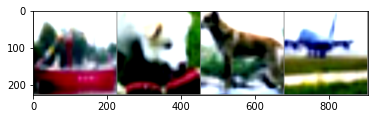

 Ship   Dog   Dog Airplane


In [4]:
#Function to show some random images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#Get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

#Show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [29]:
# hyperparameters
epochs = 10
learing_rate = 0.001

# log folder
logdir = "/content/drive/MyDrive/D7047E - ADL/logs/"
# state_dict save folder
state_dict_fldr = "/content/drive/MyDrive/D7047E - ADL/state_dicts/"

Loading AlexNet pretrained model

In [22]:
model1 = models.alexnet(pretrained=True, progress=True)
# freezing model weights
for param in model1.parameters():
    param.requires_grad = False

In [23]:
# add extra fully connected layer for CIFAR10
model1.classifier[4] = nn.Linear(4096, 1024)
model1.classifier[6] = nn.Linear(1024, 10)

In [24]:
#Instantiating CUDA device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Verifying CUDA
print(device)

#Move the input and AlexNet_model to GPU for speed if available
model1.to(device)

cuda:0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [26]:
# Loss function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model1.parameters(), lr=0.001, momentum=0.9)

Training fully connected layer with pretrained AlexNet model

In [27]:
# set writer for tensorboard
writer = SummaryWriter(logdir+"Pretrained AlexNet (CIFAR10)")

# Training
for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    validation_loss = 0.0
    val_loader_iter = iter(val_loader)
    for batch_index, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        output = model1(inputs)
        loss = criterion(output, labels)
        writer.add_scalar("Loss/train", loss, epoch)

        # validation loss
        with torch.no_grad():
          try:
            val_data = next(val_loader_iter)
          except StopIteration:
            val_loader_iter = iter(val_loader)
            val_data = next(val_loader_iter)

          val_input, val_labels = val_data[0].to(device), val_data[1].to(device)
          
          # forward validation
          val_output = model1(val_input)
          val_loss = criterion(val_output, val_labels)
          writer.add_scalar("Loss/validation", val_loss, epoch)

        # backward + optimize
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        validation_loss += val_loss.item() 
        if batch_index % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] training loss: %.3f, validation loss: %.3f' %
                  (epoch + 1, batch_index + 1, running_loss / 2000, validation_loss/2000))
            running_loss = 0.0
            validation_loss = 0.0

print('Finished Training of AlexNet')
writer.flush()
writer.close()

[6, 10000] training loss: 0.735, validation loss: 0.785
[7,  2000] training loss: 0.673, validation loss: 0.780
[7,  4000] training loss: 0.699, validation loss: 0.774
[7,  6000] training loss: 0.703, validation loss: 0.794
[7,  8000] training loss: 0.702, validation loss: 0.782
[7, 10000] training loss: 0.706, validation loss: 0.798
[8,  2000] training loss: 0.675, validation loss: 0.782
[8,  4000] training loss: 0.684, validation loss: 0.796
[8,  6000] training loss: 0.695, validation loss: 0.776
[8,  8000] training loss: 0.703, validation loss: 0.775
[8, 10000] training loss: 0.687, validation loss: 0.781
[9,  2000] training loss: 0.673, validation loss: 0.765
[9,  4000] training loss: 0.664, validation loss: 0.776
[9,  6000] training loss: 0.685, validation loss: 0.780
[9,  8000] training loss: 0.663, validation loss: 0.778
[9, 10000] training loss: 0.661, validation loss: 0.759
[10,  2000] training loss: 0.653, validation loss: 0.774
[10,  4000] training loss: 0.673, validation lo

In [32]:
# Save the weights of the trained fc layer
torch.save(model1.state_dict(), state_dict_fldr+"AlexNetPretrained_CIFAR10.pt")

In [ ]:
# Load trained extended model
model1.load_state_dict(torch.load(state_dict_fldr+'AlexNetPretrained_CIFAR10.pt', map_location=device))
model1.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Evaluate pretrained AlexNet

In [33]:
#Testing Accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model1(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 76 %


Loading AlexNet untrained model

In [38]:
model2 = models.alexnet(pretrained=False, progress=True)
optimizer_model2 = optim.SGD(model2.parameters(), lr=0.001, momentum=0.9)

In [39]:
# add extra fully connected layer for CIFAR10
model2.classifier[4] = nn.Linear(4096, 1024)
model2.classifier[6] = nn.Linear(1024, 10) 
model2.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [41]:
# set writer for tensorboard
writer = SummaryWriter(logdir+"Untrained AlexNet (CIFAR10)")

# Training
epoch = 10
for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    validation_loss = 0.0
    val_loader_iter = iter(val_loader)
    for batch_index, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer_model2.zero_grad()

        # forward
        output = model2(inputs)
        loss = criterion(output, labels)
        writer.add_scalar("Loss/train", loss, epoch)

        # validation loss
        with torch.no_grad():
          try:
            val_data = next(val_loader_iter)
          except StopIteration:
            val_loader_iter = iter(val_loader)
            val_data = next(val_loader_iter)

          val_input, val_labels = val_data[0].to(device), val_data[1].to(device)
          
          # forward validation
          val_output = model2(val_input)
          val_loss = criterion(val_output, val_labels)
          writer.add_scalar("Loss/validation", val_loss, epoch)

        # backward + optimize
        loss.backward()
        optimizer_model2.step()

        # print statistics
        running_loss += loss.item()
        validation_loss += val_loss.item() 
        if batch_index % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] training loss: %.3f, validation loss: %.3f' %
                  (epoch + 1, batch_index + 1, running_loss / 2000, validation_loss/2000))
            running_loss = 0.0
            validation_loss = 0.0

print('Finished Training of AlexNet')
writer.flush()
writer.close()

[1,  2000] training loss: 2.231, validation loss: 2.233
[1,  4000] training loss: 1.935, validation loss: 1.930
[1,  6000] training loss: 1.752, validation loss: 1.736
[1,  8000] training loss: 1.636, validation loss: 1.629
[1, 10000] training loss: 1.565, validation loss: 1.559
[2,  2000] training loss: 1.486, validation loss: 1.478
[2,  4000] training loss: 1.405, validation loss: 1.425
[2,  6000] training loss: 1.351, validation loss: 1.349
[2,  8000] training loss: 1.296, validation loss: 1.302
[2, 10000] training loss: 1.233, validation loss: 1.242
[3,  2000] training loss: 1.152, validation loss: 1.171
[3,  4000] training loss: 1.117, validation loss: 1.135
[3,  6000] training loss: 1.051, validation loss: 1.082
[3,  8000] training loss: 1.029, validation loss: 1.041
[3, 10000] training loss: 0.997, validation loss: 1.017
[4,  2000] training loss: 0.915, validation loss: 0.979
[4,  4000] training loss: 0.900, validation loss: 0.954
[4,  6000] training loss: 0.886, validation loss

In [42]:
#Testing Accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 79 %


In [43]:
# save trained AlexNet on CIFAR10
torch.save(model2.state_dict(), state_dict_fldr+"AlexNetUntrained_CIFAR10.pt")

In [37]:
# load trained extended model2
model2.load_state_dict(torch.load(state_dict_fldr+'AlexNetUntrained_CIFAR10.pt', map_location=device))
model2.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 